In [1]:
import sys
sys.argv = ['']

In [2]:
#from diffuser.utils.arrays import to_torch, to_np, to_device
#from diffuser.datasets.d4rl import suppress_output
#from scripts.buffer_utils import LoadSequenceDataset
#from scripts.buffer_utils import OptimalBuffer
from scripts.mopo.utils_trans import RewardPredictingModel 
#from scripts.buffer_utils import augment_trajectories_new
import diffuser.utils as utils

/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import shutil 
import argparse 
import time 
import pickle
import sys
import os
import torch
import random
import importlib
from collections import defaultdict
import pdb
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from time import time

In [5]:
from collections import defaultdict

In [6]:
from sklearn.cluster import KMeans

In [7]:
import d4rl

No module named 'flow'
/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:51:11


In [8]:
from copy import copy

In [9]:
from ml_logger import logger

In [10]:
def import_config(config_name):
    module_path = f"detail_configs.{config_name}"
    try:
        module = importlib.import_module(module_path)
        return module.Config
    except ImportError:
        print(f"Error: Module '{config_name}' not found or has no 'Config' attribute.")
        return None


def to_np(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return x


def to_torch(x, dtype=None, device=None):
    dtype = dtype or DTYPE
    device = device or DEVICE
    if type(x) is dict:
        return {k: to_torch(v, dtype, device) for k, v in x.items()}
    elif torch.is_tensor(x):
        return x.to(device).type(dtype)
        # import pdb; pdb.set_trace()
    return torch.tensor(x, dtype=dtype, device=device)


def to_device(x, device):
    if torch.is_tensor(x):
        return x.to(device)
    elif type(x) is dict:
        return {k: to_device(v, device) for k, v in x.items()}
    else:
        print(f"Unrecognized type in `to_device`: {type(x)}")
        pdb.set_trace()
    # return [x.to(device) for x in xs]


def task_dataset(seq_dataset):

    tasks = []

    task_data = defaultdict(list)
    rewards = seq_dataset["rew"]

    l = rewards.shape[0]
    for i in range(l):

        for k in seq_dataset:
            task_data[k].append(seq_dataset[k][i])

        if (i + 1) % 50 == 0:
            for k in task_data:
                task_data[k] = np.array(task_data[k])
            tasks.append(task_data)
            task_data = defaultdict(list)

    if len(task_data) > 0:
        for k in task_data:
            task_data[k] = np.array(task_data[k])
        tasks.append(task_data)

    return tasks


def load_data(data_file):
    with open(data_file, "rb") as fp:
        ds = pickle.load(fp)
    return ds


def obtain_region_idx(idx):
    digits = []
    l = len(idx)
    for i in range(l):
        digits.append(idx[i])
    return digits


class LoadSequenceDataset:
    def __init__(self, env_name, data_file):
        if "Maze" in env_name:
            dataset = load_data(data_file)
            if "AntMaze_UMaze-v4" in env_name:
                dataset_name = "antmaze-umaze-v0"
            elif "AntMaze_Medium-v4" in env_name:
                dataset_name = "antmaze-medium-v0"
            elif "AntMaze_Large-v4" in env_name:
                dataset_name = "antmaze-large-v0"
            elif "PointMaze_UMaze-v3" in env_name:
                dataset_name = "pointmaze-umaze-v0"
            elif "PointMaze_Medium-v3" in env_name:
                dataset_name = "pointmaze-medium-v1"
            elif "PointMaze_Large-v3" in env_name:
                dataset_name = "pointmaze-large-v1"
            else:
                raise NotImplementedError
            max_path_length = 600
        else:
            env = gym.make(env_name)
            dataset = env.get_dataset()
            max_path_length = 1000

        self.data_size = dataset["rewards"].shape[0]
        print(f"\nnumber of offline data is {dataset['rewards'].shape[0]}\n")

        paths = []
        current_path = {"obs": [], "act": [], "rew": [], "dones": [], "next_obs": []}

        use_timeouts = "timeouts" in dataset

        print(use_timeouts)
        move = []

        for i in range(dataset["rewards"].shape[0] - 1):
            if "Maze" in env_name:
                current_path["obs"].append(dataset["observations"]["observation"][i])
                current_path["dones"].append(dataset["terminations"][i])
                current_path["next_obs"].append(
                    dataset["observations"]["observation"][i + 1]
                )
            else:
                current_path["obs"].append(dataset["observations"][i])
                current_path["dones"].append(dataset["terminals"][i])
                current_path["next_obs"].append(dataset["observations"][i + 1])

            current_path["act"].append(dataset["actions"][i])
            current_path["rew"].append(dataset["rewards"][i])

            if use_timeouts:
                final_timestep = dataset["timeouts"][i]
            else:
                final_timestep = len(current_path["obs"]) == max_path_length

            done = (
                dataset["terminations"][i]
                if "Maze" in env_name
                else dataset["terminals"][i]
            )
            if bool(done) or final_timestep:
                for _ in current_path:
                    current_path[_] = np.array(current_path[_])
                if current_path["obs"].shape[0] > 1:
                    move.append(current_path["obs"][1:] - current_path["obs"][:-1])
                task_path = task_dataset(current_path)
                paths.extend(task_path)
                current_path = {
                    "obs": [],
                    "act": [],
                    "rew": [],
                    "dones": [],
                    "next_obs": [],
                }
        self.paths = paths
        self.num_traj = len(self.paths)
        self.move_mean = np.concatenate(move, axis=0).mean(0)
        self.move_std = np.concatenate(move, axis=0).std(0)

    def get_full_info_traj(self, idx, gamma=0.99):
        obs = []
        act = []
        rew = []
        next_obs = []
        dones = []
        region_idx = []
        obs = np.copy(self.paths[idx]["obs"])
        act = np.copy(self.paths[idx]["act"])
        rew = np.copy(self.paths[idx]["rew"])
        next_obs = np.copy(self.paths[idx]["next_obs"])
        dones = np.copy(self.paths[idx]["dones"])

        total_return = np.sum(rew)
        discounted_return = 0
        for i in range(rew.shape[0] - 1, -1, -1):
            discounted_return = discounted_return * gamma + rew[i]
        return {
            "obs": obs,
            "act": act,
            "rew": rew,
            "next_obs": next_obs,
            "dones": dones,
            "total_return": total_return,
            "discounted_return": discounted_return,
            "horizon": rew.shape[0],
            "trajectory_idx": idx,
        }


class OptimalBuffer:
    def __init__(self, horizon, ratio=0.1, gamma=0.99):
        self.gamma = gamma
        self.ratio = ratio
        self.info = []
        self.horizon = horizon
        self.region_map = defaultdict(list)
        self.returns_list = []

    def insert_traj(self, info):
        current_total_reward = 0
        current_discounted_reward = 0
        for i in range(info["horizon"] - 1, -1, -1):
            current_total_reward += info["rew"][i]
            current_discounted_reward = (
                current_discounted_reward * self.gamma + info["rew"][i]
            )
            if info["horizon"] - i >= self.horizon:
                current_info = {
                    "discounted_reward": current_discounted_reward,
                    "obs": info["obs"][i : i + self.horizon],
                    "segment_idx": i,
                    "traj_idx": info["trajectory_idx"],
                    "rew": info["rew"][i : i + self.horizon],
                }
                self.info.append(current_info)
                

    def finalize(
        self,
    ):
        num_seg = len(self.info)
        all_obs = np.array([info["obs"] for info in self.info]).mean(axis=-1)
        kmeans = KMeans(n_clusters=10, n_init="auto").fit(all_obs)
        labels = kmeans.labels_
        for i in range(num_seg):
            self.info[i]["region_idx"] = str(labels[i])
            self.region_map[str(labels[i])].append(i)
            self.returns_list.append(sum(self.info[i]["rew"]))
        self.returns_list = np.array(self.returns_list)
        self.returns_list -= self.returns_list.max()
        self.returns_list = np.exp(self.returns_list)  # make if positive

    def sample_batch_traj(self, optim_batch, region_avoid):
        # stored in (d-rtg, obs:(100, obs_dim))

        sample_idx = []

        for k in self.region_map:
            if k not in region_avoid:
                sample_idx += self.region_map[k]

        sample_p = self.returns_list[np.array(sample_idx)]
        sample_p = sample_p / sample_p.sum()
        batch_info = []
        batch_index = np.random.choice(
            sample_idx, size=optim_batch, replace=False, p=sample_p
        )
        batch_info = [self.info[_] for _ in batch_index]

        return batch_info


def cosine_similarity(x, y):
    x_norm = np.linalg.norm(x, axis=1, keepdims=True)
    y_norm = np.linalg.norm(y, axis=1, keepdims=True)
    similarity = np.dot(x / x_norm, (y / y_norm).transpose())
    return similarity


def comp_distance(x, y):
    return np.linalg.norm(x - y, axis=-1)


class Timer:
    def __init__(self):
        self.total_clapsed = 0
        self.start = time()
        self.call_time = 0

    def __call__(self):

        clapsed = time() - self.start
        self.call_time += 1

        self.total_clapsed += clapsed
        self.start = time()
        return self.total_clapsed

    def mean(
        self,
    ):

        clapsed = time() - self.start
        self.call_time += 1

        self.total_clapsed += clapsed
        self.start = time()
        return self.total_clapsed / self.call_time


def get_conditions(conditions, start, x, device):

    obs_dim = x.shape[-1]

    conditions[:, :, obs_dim:] = 0
    conditions[:, :start, :obs_dim] = 0
    conditions[:, :start, obs_dim:] = x[:, -start:, :]
    conditions = torch.tensor(conditions).to(device)

    return conditions

In [11]:

class StitchDataset:
    def __init__(self, trajectories):
        self.paths = trajectories
        self.num_traj = len(self.paths)
        print(f"processed {self.num_traj} trajectories")

    def get_full_info_traj(self, idx, gamma=0.99):
        obs = []
        act = []
        rew = []
        next_obs = []
        dones = []
        region_idx = []
        obs = np.copy(self.paths[idx]["obs"])
        act = np.copy(self.paths[idx]["act"])
        rew = np.copy(self.paths[idx]["rew"])
        next_obs = np.copy(self.paths[idx]["next_obs"])
        dones = np.copy(self.paths[idx]["dones"])
        region_idx = self.paths[idx]["region_idx"]

        total_return = np.sum(rew)
        discounted_return = 0
        for i in range(rew.shape[0] - 1, -1, -1):
            discounted_return = discounted_return * gamma + rew[i]
        return {
            "obs": obs,
            "act": act,
            "rew": rew,
            "next_obs": next_obs,
            "dones": dones,
            "total_return": total_return,
            "discounted_return": discounted_return,
            "horizon": rew.shape[0],
            "region_idx": region_idx,
            "trajectory_idx": idx,
        }


class StitchBuffer:
    def __init__(self, horizon, ratio=0.1, gamma=0.99):
        self.gamma = gamma
        self.ratio = ratio
        self.info = []
        self.horizon = horizon
        self.region_map = defaultdict(list)
        self.count = 0
        self.returns_list = []

    def insert_traj(self, info):
        current_total_reward = 0
        current_discounted_reward = 0
        for i in range(info["horizon"] - 1, -1, -1):
            current_total_reward += info["rew"][i]
            current_discounted_reward = (
                current_discounted_reward * self.gamma + info["rew"][i]
            )
            if info["horizon"] - i >= self.horizon:
                current_info = {
                    "discounted_reward": current_discounted_reward,
                    "obs": info["obs"][i : i + self.horizon],
                    "segment_idx": i,
                    "region_idx": info["region_idx"][i : i + self.horizon],
                    "traj_idx": info["trajectory_idx"],
                    "rew": info["rew"][i : i + self.horizon],
                }
                self.info.append(current_info)
                self.region_map[info["region_idx"]].append(self.count)
                self.count += 1
                self.returns_list.append(sum(info["rew"]))

    def finalize(
        self,
    ):
        self.returns_list = np.array(self.returns_list)
        self.returns_list -= self.returns_list.min()

    def sample_batch_traj(self, optim_batch, region_avoid):
        # stored in (d-rtg, obs:(100, obs_dim))

        sample_idx = []
        for k in self.region_map:
            if k not in region_avoid:
                sample_idx += self.region_map[k]

        sample_p = self.returns_list[np.array(sample_idx)]
        sample_p = sample_p / sample_p.sum()

        batch_info = []
        batch_index = np.random.choice(
            sample_idx, size=optim_batch, replace=False, p=sample_p
        )
        batch_info = [self.info[_] for _ in batch_index]

        return batch_info


def process_stitched_trajectories(origin_trj1, stitch_trj, origin_trj2):
    """concatenate one origin_trj and the corresponding stitch_trj"""

    keys = ["obs", "act", "rew", "next_obs", "dones"]
    new_trj = {}
    for k in keys:
        assert k in origin_trj1, f"{k} not in origin_trj1"
        assert k in origin_trj2, f"{k} not in origin_trj2"
        assert k in stitch_trj, f"{k} not in stitch_trj"

        new_trj[k] = np.concatenate(
            [origin_trj1[k], stitch_trj[k], origin_trj2[k]], axis=0
        )
    new_trj["region_idx"] = stitch_trj["region_idx"]
    return new_trj

In [12]:
Config = import_config('hopper_medium_replay_v2_task')

# log path
BASE_WEIGHTS_PATH = os.path.join(Config.bucket, Config.dataset)
save_config_path = os.path.join(BASE_WEIGHTS_PATH, Config.prefix, "config")
logger.configure(save_config_path)
torch.backends.cudnn.benchmark = True

# training dataset for Diffuser
dataset_config = utils.Config(
    "datasets.CondSequenceDataset",
    savepath="dataset_config.pkl",
    env=Config.dataset,
    horizon=Config.horizon,
    normalizer=Config.normalizer,
    preprocess_fns=Config.preprocess_fns,
    use_padding=Config.use_padding,
    max_path_length=Config.max_path_length,
    include_returns=Config.include_returns,
    returns_scale=Config.returns_scale,
    data_file=Config.data_file,
    task_data=True,
    aug_data_file=None,
)

dataset = dataset_config()
renderer = None
observation_dim = dataset.observation_dim
action_dim = dataset.action_dim
# loadpath = os.path.join(Config.bucket, Config.dataset, Config.prefix, "checkpoint")
# print("\n\nloadpath = ", loadpath, end="\n\n")

# model configs
observation_dim = dataset.observation_dim
action_dim = dataset.action_dim
transition_dim = observation_dim

# model_config = utils.Config(
#     Config.model,
#     savepath="model_config.pkl",
#     horizon=Config.horizon,
#     transition_dim=transition_dim,
#     cond_dim=observation_dim,
#     dim_mults=Config.dim_mults,
#     dim=Config.dim,
#     returns_condition=Config.returns_condition,
#     device=Config.device,
# )

# diffusion_config = utils.Config(
#     Config.diffusion,
#     savepath="diffusion_config.pkl",
#     horizon=Config.horizon,
#     observation_dim=observation_dim,
#     action_dim=action_dim,
#     n_timesteps=Config.n_diffusion_steps,
#     loss_type=Config.loss_type,
#     clip_denoised=Config.clip_denoised,
#     predict_epsilon=Config.predict_epsilon,
#     hidden_dim=Config.hidden_dim,
#     ## loss weighting
#     action_weight=Config.action_weight,
#     loss_weights=Config.loss_weights,
#     loss_discount=Config.loss_discount,
#     returns_condition=Config.returns_condition,
#     device=Config.device,
#     condition_guidance_w=Config.condition_guidance_w,
# )

# trainer_config = utils.Config(
#     utils.Trainer,
#     savepath="trainer_config.pkl",
#     train_batch_size=Config.batch_size,
#     train_lr=Config.learning_rate,
#     gradient_accumulate_every=Config.gradient_accumulate_every,
#     ema_decay=Config.ema_decay,
#     sample_freq=Config.sample_freq,
#     save_freq=Config.save_freq,
#     log_freq=Config.log_freq,
#     label_freq=int(Config.n_train_steps // Config.n_saves),
#     save_parallel=Config.save_parallel,
#     bucket=Config.bucket,
#     n_reference=Config.n_reference,
#     n_samples=Config.n_samples,
#     train_device=Config.device,
# )
# model = model_config()
# diffusion = diffusion_config(model)
# trainer = trainer_config(diffusion, dataset, renderer)

# # load Diffuser model
# loadpath = os.path.join(loadpath, f"state_1000000.pt")
# state_dict = torch.load(loadpath, map_location=Config.device)
# trainer.step = state_dict["step"]
# trainer.model.load_state_dict(state_dict["model"])
# trainer.ema_model.load_state_dict(state_dict["ema"])

# # load Dynamic model
# dynamics_model = RewardPredictingModel(
#     device=Config.device,
#     env_name=Config.dataset,
#     load_path=Config.dynamic_model_path,
# )

env_name = Config.dataset
if "Maze" not in env_name:
    data_file = None
else:
    if "AntMaze_UMaze-v4" in env_name:
        dataset_name = "antmaze-umaze-v0"
    elif "AntMaze_Medium-v4" in env_name:
        dataset_name = "antmaze-medium-v0"
    elif "AntMaze_Large-v4" in env_name:
        dataset_name = "antmaze-large-v0"
    elif "PointMaze_UMaze-v3" in env_name:
        dataset_name = "pointmaze-umaze-v1"
    elif "PointMaze_Medium-v3" in env_name:
        dataset_name = "pointmaze-medium-v1"
    elif "PointMaze_Large-v3" in env_name:
        dataset_name = "pointmaze-large-v1"

    dataset_name = dataset_name + ".pkl"
    data_file = Config.data_file + dataset_name
env_dataset = LoadSequenceDataset(env_name=Config.dataset, data_file=data_file)
data_buffer = OptimalBuffer(horizon=Config.horizon)
for i in range(env_dataset.num_traj):
    info = env_dataset.get_full_info_traj(i)
    data_buffer.insert_traj(info)
data_buffer.finalize()

✓ created a new logging client
Dashboard: http://app.dash.ml/common/users/cc1547/projects/rainbow/diffstitch/diffuser/gym_mujoco/task/hopper-medium-replay-v2/diffuser/default_inv/predict_epsilon_100_1000000.0/dropout_0.25/hopper-medium-replay-v2/task/50/config
Log_directory: /common/home/cc1547/projects/diff_stitch
[ utils/config ] Imported diffuser.datasets:CondSequenceDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.CondSequenceDataset'>
    aug_data_file: None
    data_file: None
    env: hopper-medium-replay-v2
    horizon: 50
    include_returns: True
    max_path_length: 50
    normalizer: CDFNormalizer
    preprocess_fns: []
    returns_scale: 150.0
    task_data: True
    use_padding: True

[ utils/config ] Saved config to: dataset_config.pkl

class =  <class 'diffuser.datasets.sequence.CondSequenceDataset'>
kwargs =  {}


load datafile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.79it/s]


[ datasets/buffer ] Finalized replay buffer | 9071 episodes  | Avg path lengths 44.32
[ datasets/buffer ] Fields:
    observations: (9071, 50, 11)
    rewards: (9071, 50, 1)
    actions: (9071, 50, 3)
    terminals: (9071, 50, 1)
    normed_observations: (9071, 50, 11)
    normed_actions: (9071, 50, 3)


load datafile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 17.01it/s]



number of offline data is 402000

True


In [13]:
env_dataset.num_traj

9068

In [14]:
len(data_buffer.info)

7106

In [15]:
def read_stitched_data(aug_list, trj1_dataset):
    stitched_trjs = []
    for i in range(len(aug_list)):
        rew = aug_list[i][9][1:]
        if len(rew.shape) == 2:
            rew = rew.squeeze(-1)
        stitch_trj = dict(
            obs = aug_list[i][7][1:],
            act = aug_list[i][8][1:],
            rew = rew,
            next_obs = aug_list[i][10][1:],
            dones = aug_list[i][11],
            region_idx = aug_list[i][12],
        )# the first state in stitch is the last state in trj1
    
        traj2_idx = aug_list[i][2]
        traj2_segment_idx = aug_list[i][3]
        trj2 = env_dataset.get_full_info_traj(traj2_idx)
        for k in ['obs', 'act', 'rew', 'next_obs', 'dones']:
            trj2[k] = trj2[k][traj2_segment_idx:]
    
        traj1_idx = aug_list[i][0]
        traj1_segment_idx = aug_list[i][1]
        trj1 = trj1_dataset.get_full_info_traj(traj1_idx)
        for k in ['obs', 'act', 'rew', 'next_obs', 'dones']:
            trj1[k] = trj1[k][:traj1_segment_idx+Config.horizon] 
    
        new_trj = process_stitched_trajectories(trj1, stitch_trj, trj2)
        stitched_trjs.append(new_trj)
    return stitched_trjs

In [17]:
with open(f"./scripts/gym_vad/round1_stitch_{Config.dataset}_H50.pkl", 'rb') as f:
    aug_list_1 = pickle.load(f)

# with open(f"./scripts/gym_v3/round2_stitch_{Config.dataset}_H40.pkl", 'rb') as f:
#     aug_list_2 = pickle.load(f)


In [18]:
len(aug_list_1)

6286

In [19]:
trj2_idx = [l[2] for l in aug_list_1]

In [20]:
trj1_idx = [l[0] for l in aug_list_1]

In [21]:
np.unique(trj2_idx+trj1_idx).shape

(2623,)

In [60]:
len(aug_list_1)

6339

In [22]:
len(data_buffer.info)

7106

In [23]:
trj2_idx = aug_list_2[0][2]
trj1_idx = aug_list_2[0][0]

NameError: name 'aug_list_2' is not defined

In [138]:
trj2_idx

5201

In [139]:
traj2_segment_idx = aug_list_2[0][3]
traj2_segment_idx

0

In [117]:
trj1_idx

1640

In [140]:
traj1_segment_idx = aug_list_2[0][1]
traj1_segment_idx

1

In [120]:
aug_list_1[0][7].shape

(2, 11)

In [125]:
np.linalg.norm(stitch_1[0]['obs'][40]-stitch_1[0]['obs'][41])

0.8446584

In [124]:
np.linalg.norm(stitch_1[0]['obs'][39]-stitch_1[0]['obs'][41])

2.6601565

In [126]:
stitch_1[0]['obs'][39,]

array([ 0.91620415, -0.04483864, -1.1558075 , -0.2513629 , -0.22091874,
        4.721695  , -1.7562622 ,  2.6023722 , -1.3889214 ,  2.6942945 ,
       10.        ], dtype=float32)

In [127]:
stitch_1[0]['obs'][40,]

array([ 0.90151906, -0.02970576, -1.1710083 , -0.23382989, -0.1050427 ,
        4.43068   , -1.912677  ,  1.1801413 , -2.4106526 ,  1.6894422 ,
       10.        ], dtype=float32)

In [23]:
stitch_1 = read_stitched_data(aug_list_1, env_dataset)
stitch_1_dataset = StitchDataset(stitch_1)

processed 6286 trajectories


In [25]:
stitch_2 = read_stitched_data(aug_list_2, stitch_1_dataset)
stitch_2_dataset = StitchDataset(stitch_2)

NameError: name 'aug_list_2' is not defined

In [24]:
def increased_return(aug_list, trj1_dataset, discount=0.99):
    increased = []
    for i in range(len(aug_list)):
        rew = aug_list[i][9][1:]
        if len(rew.shape) == 2:
            rew = rew.squeeze(-1)
        
    
        traj2_idx = aug_list[i][2]
        traj2_segment_idx = aug_list[i][3]
        trj2 = env_dataset.get_full_info_traj(traj2_idx)
        trj2_rew = trj2['rew'][traj2_segment_idx:]
        
    
        traj1_idx = aug_list[i][0]
        traj1_segment_idx = aug_list[i][1]
        trj1 = trj1_dataset.get_full_info_traj(traj1_idx)
        trj1_rew = trj1['rew'][:traj1_segment_idx+Config.horizon]

        new_rew = np.concatenate([trj1_rew, rew, trj2_rew], axis=0)
    
        origin_return = 0
        for i in range(trj1_rew.shape[0]-1, -1, -1):
            origin_return = trj1_rew[i] + origin_return*discount
        new_return = 0
        for i in range(new_rew.shape[0]-1, -1, -1):
            new_return = new_rew[i] + new_return * discount
        increase_ratio = new_return / abs(origin_return)
        increased.append(increase_ratio)
        
    return np.array(increased)

In [25]:
round1_increase = increased_return(aug_list_1, env_dataset)

(array([  3.,   1.,   2.,   3.,   1.,   0.,   1.,   4.,  36.,  67.,  88.,
        179., 346., 364., 499., 518., 483., 443., 530., 394., 446., 358.,
        246., 286., 254., 162., 143.,  87.,  66.,  61.,  26.,  35.,  23.,
         32.,  13.,  18.,  11.,   5.,  10.,   4.,   2.,   3.,   0.,   1.,
          5.,   3.,   1.,   2.,   2.,   1.,   0.,   0.,   2.,   0.,   6.,
          2.,   1.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.0605971 , 1.11360949, 1.16662188, 1.21963427, 1.27264666,
        1.32565905, 1.37867144, 1.43168383, 1.48469622, 1.5377086 ,
        1.59072099, 1.64373338, 1.69674577, 1.74975816, 1.80277055,
        1.85578294, 1.90879533, 1.96180772, 2.01482011, 2.0678325 ,
        2.12084488, 2.17385727, 2.22686966, 2.

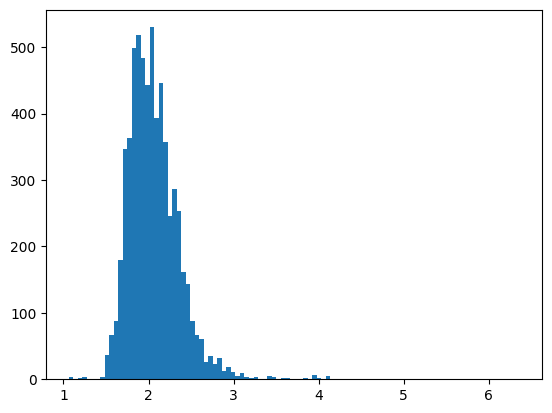

In [26]:
plt.hist(round1_increase, bins=100)

In [27]:
round1_increase.mean()

2.0631162036874895

In [28]:
(round1_increase>=1).mean()

1.0

In [29]:
def trj2_gt_trj1(aug_list, trj1_dataset, discount=0.99):
    increased = []
    for i in range(len(aug_list)):
        rew = aug_list[i][9][1:]
        if len(rew.shape) == 2:
            rew = rew.squeeze(-1)
        
    
        traj2_idx = aug_list[i][2]
        traj2_segment_idx = aug_list[i][3]
        trj2 = env_dataset.get_full_info_traj(traj2_idx)
        trj2_rew = trj2['rew'][traj2_segment_idx:]
        
    
        traj1_idx = aug_list[i][0]
        traj1_segment_idx = aug_list[i][1]
        trj1 = trj1_dataset.get_full_info_traj(traj1_idx)
        trj1_rew = trj1['rew'][:traj1_segment_idx+Config.horizon]

        trj2_rew = np.concatenate([trj2_rew], axis=0)
    
        trj1_return = 0
        for i in range(trj1_rew.shape[0]-1, -1, -1):
            trj1_return = trj1_rew[i] + trj1_return*discount
        
        trj2_return = 0
        for i in range(trj2_rew.shape[0]-1, -1, -1):
            trj2_return = trj2_rew[i] + trj2_return * discount
        
        increase_ratio = trj2_return / abs(trj1_return)
        increased.append(increase_ratio)
        
    return np.array(increased)

In [30]:
def reward_per_step(aug_list, trj1_dataset, discount=0.99):
    increased = []
    for i in range(len(aug_list)):
        rew = aug_list[i][9][1:]
        if len(rew.shape) == 2:
            rew = rew.squeeze(-1)
        
    
        traj2_idx = aug_list[i][2]
        traj2_segment_idx = aug_list[i][3]
        trj2 = env_dataset.get_full_info_traj(traj2_idx)
        trj2_rew = trj2['rew'][traj2_segment_idx:]

        trj2_rew = np.concatenate([trj2_rew], axis=0)
    
        traj1_idx = aug_list[i][0]
        traj1_segment_idx = aug_list[i][1]
        trj1 = trj1_dataset.get_full_info_traj(traj1_idx)
        trj1_rew = trj1['rew'][:traj1_segment_idx+Config.horizon]

        new_rew = np.concatenate([trj1_rew, rew, trj2_rew], axis=0)
    
        increased.append(new_rew.mean() / trj1_rew.mean())
        
    return np.array(increased)

In [31]:
trj2_minus_trj1 = trj2_gt_trj1(aug_list_1, env_dataset)

(array([  6.,   2.,   1.,   0.,   2.,  11.,  14.,  24.,  40.,  73., 129.,
        230., 316., 429., 503., 408., 445., 422., 377., 372., 379., 375.,
        351., 234., 222., 211., 181., 121., 109.,  54.,  40.,  51.,  28.,
         19.,  20.,   9.,  14.,  11.,   4.,   3.,   7.,   2.,   1.,   3.,
          1.,   0.,   6.,   2.,   2.,   0.,   2.,   1.,   1.,   0.,   1.,
          0.,   0.,   2.,  10.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.09630327, 0.17455769, 0.25281211, 0.33106654, 0.40932096,
        0.48757538, 0.5658298 , 0.64408422, 0.72233865, 0.80059307,
        0.87884749, 0.95710191, 1.03535633, 1.11361076, 1.19186518,
        1.2701196 , 1.34837402, 1.42662844, 1.50488287, 1.58313729,
        1.66139171, 1.73964613, 1.81790056, 1.

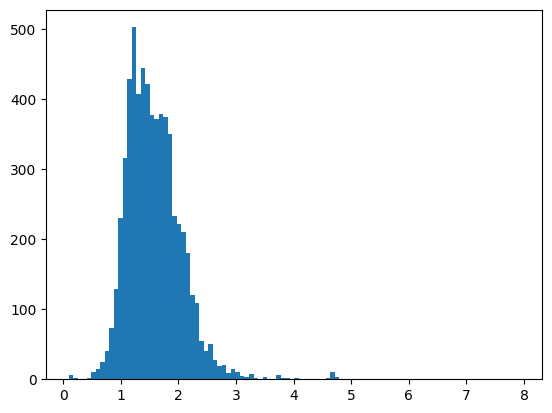

In [32]:
plt.hist(trj2_minus_trj1, bins=100)

In [33]:
(trj2_minus_trj1>1).mean()

0.9357301940820871

In [34]:
reward_pt = reward_per_step(aug_list_1, env_dataset)

(array([  6.,   2.,   1.,   0.,   2.,  11.,  14.,  24.,  40.,  73., 129.,
        230., 316., 429., 503., 408., 445., 422., 377., 372., 379., 375.,
        351., 234., 222., 211., 181., 121., 109.,  54.,  40.,  51.,  28.,
         19.,  20.,   9.,  14.,  11.,   4.,   3.,   7.,   2.,   1.,   3.,
          1.,   0.,   6.,   2.,   2.,   0.,   2.,   1.,   1.,   0.,   1.,
          0.,   0.,   2.,  10.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.09630327, 0.17455769, 0.25281211, 0.33106654, 0.40932096,
        0.48757538, 0.5658298 , 0.64408422, 0.72233865, 0.80059307,
        0.87884749, 0.95710191, 1.03535633, 1.11361076, 1.19186518,
        1.2701196 , 1.34837402, 1.42662844, 1.50488287, 1.58313729,
        1.66139171, 1.73964613, 1.81790056, 1.

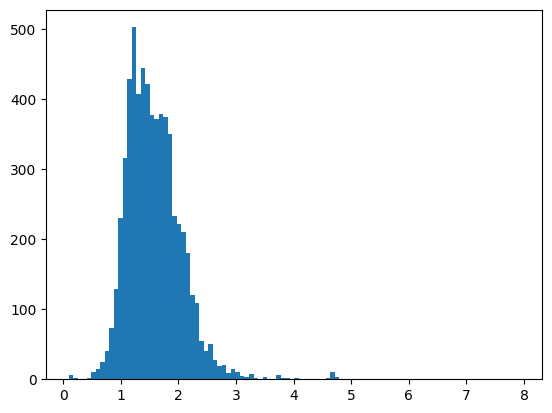

In [35]:
plt.hist(trj2_minus_trj1, bins=100)

In [36]:
reward_pt.mean()

1.2747536

In [37]:
(reward_pt>=1).mean()

0.9317531021317212

In [38]:
def post_process_stitched_trjs(stitched_trjs, last=False):
    # for trj in stitched_trjs:
    #     trj['dones'][-1] = True
    
    post_process_stitch = defaultdict(list)
    for trj in stitched_trjs:
        timeouts = copy(trj['dones'])
        timeouts[-1] = not trj['dones'][-1]
        
        post_process_stitch['actions'].extend(trj['act'])
        post_process_stitch['observations'].extend(trj['obs'])
        post_process_stitch['terminals'].extend(trj['dones'])
        post_process_stitch['rewards'].extend(trj['rew'])
        post_process_stitch['timeouts'].extend(timeouts)
    for k in post_process_stitch:

        post_process_stitch[k] = np.array(post_process_stitch[k])
    return post_process_stitch

In [39]:
post_processed_stitch1 = post_process_stitched_trjs(stitch_1)


In [135]:
post_processed_stitch2 = post_process_stitched_trjs(stitch_2)

In [95]:
dones = np.array([sum(seq['dones']) for seq in stitch_2])

NameError: name 'stitch_2' is not defined

In [ ]:
post_processed_stitch1['timeouts'].sum()

In [107]:
Config.dataset

'walker2d-medium-replay-v2'

In [22]:
final_done = [stitch_1[idx]['dones'][-1] for idx in indices]

In [40]:
for k in post_processed_stitch1:
    print(f'{k} shape: {post_processed_stitch1[k].shape}')

actions shape: (722401, 3)
observations shape: (722401, 11)
terminals shape: (722401,)
rewards shape: (722401,)
timeouts shape: (722401,)


In [24]:
stitch_1[1]['act'][40]

array([-0.71396416,  0.30277994,  0.6727203 ,  0.83401775,  0.60441285,
       -0.897235  ], dtype=float32)

In [21]:
for k in post_processed_stitch2:
    print(f'{k} shape: {post_processed_stitch2[k].shape}')

actions shape: (627833, 3)
observations shape: (627833, 11)
terminals shape: (627833,)
rewards shape: (627833,)
timeouts shape: (627833,)


In [41]:
file1_name = f"./scripts/gym_vad/round1_stitch_{Config.dataset}_H50-v2.pkl"
# file2_name = f"./scripts/gym_v3/round2_stitch_{Config.dataset}_H40-v2.pkl"


In [42]:
with open(file1_name, 'wb') as f:
    pickle.dump(post_processed_stitch1, f)

# with open(file2_name, 'wb') as f:
#     pickle.dump(post_processed_stitch2, f)


In [97]:
idx_80 = np.concatenate([np.where(trans_len1 == 81)[0], np.where(trans_len1 == 80)[0]])

In [98]:
idx_80.shape

(1886,)

In [43]:
i = 0
trj_ = []
for idx in range(len(aug_list_1)):
    trj2_idx = aug_list_1[idx][2]
    trj1_idx = aug_list_1[idx][0]
    if trj2_idx == trj1_idx + 1:
        i += 1
        trj_.append(trj1_idx)

In [44]:
trans_len1[:10]

NameError: name 'trans_len1' is not defined

In [45]:
i

62

In [46]:
np.unique(trj_).shape

(41,)

In [71]:
trj_idx = np.array([path['traj_idx'] for path in data_buffer.info])

In [58]:
np.unique(trj_idx).shape

(9131,)

In [32]:
path_len = np.array([path['obs'].shape[0] for path in data_buffer.info])

In [85]:
path_first_obs = np.array([path['obs'][0] for path in data_buffer.info])

In [86]:
path_lat_obs = np.array([path['obs'][-1] for path in data_buffer.info])

In [90]:
np.dot(path_lat_obs[5761] / np.linalg.norm(path_lat_obs[5761]), path_first_obs[5762]/np.linalg.norm(path_first_obs[5762]))

0.9980928

In [76]:
path_first_obs[5762]

array([ 1.3244245 ,  0.30586362,  0.03146961,  0.02950273,  0.82102716,
       -0.03242583, -0.81312454, -0.81771326,  2.9789536 , -0.38011533,
       -1.767794  ,  0.12680785, -0.0884762 , -0.190126  , -1.3224595 ,
       -3.9007967 ,  0.45649   ], dtype=float32)

In [89]:
np.linalg.norm(path_lat_obs[5761]- path_first_obs[5762])

0.40676054

In [87]:
num_ = path_lat_obs.shape[0]

dist = []
for i in range(num_):
    dist.append(np.linalg.norm(path_lat_obs[i:i+1] - path_first_obs, axis=-1))
    if i % 1000 == 0:
        print(f'processed {i}th sample')

processed 0th sample
processed 1000th sample
processed 2000th sample
processed 3000th sample
processed 4000th sample
processed 5000th sample
processed 6000th sample
processed 7000th sample


In [123]:
dist = np.array(dist)
dist.shape

(9131, 9131)

In [127]:
dist[5761].argsort()[:10]

array([5762, 6219, 6850, 6576, 3479, 6797, 5686, 5633, 6889, 7017])

In [33]:
dist_idx = []
for i in range(num_):
    if dist[i].argmin() == i+1:
        dist_idx.append(i)

In [34]:
len(dist_idx)

852

In [129]:
sim[5761].argsort()[-10:][::-1]

array([5762, 6219, 6850, 4139, 3796, 4736, 6797, 5996, 5633, 6651])

In [88]:
num_ = path_lat_obs.shape[0]
x_norm = np.linalg.norm(path_lat_obs, axis=1, keepdims=True)
x_normed = path_lat_obs / x_norm

y_norm = np.linalg.norm(path_first_obs, axis=1, keepdims=True)
y_normed = (path_first_obs / y_norm).transpose()


    
sim = []
for i in range(num_):
    sim.append(np.dot(x_normed[i:i+1], y_normed))
    if i % 1000 == 0:
        print(f'processed {i}th sample')

processed 0th sample
processed 1000th sample
processed 2000th sample
processed 3000th sample
processed 4000th sample
processed 5000th sample
processed 6000th sample
processed 7000th sample


In [27]:
sim = np.concatenate(sim, axis=0)

In [93]:
cnt = 0
for i in range(num_):
    if sim[i].argmax() == i+1:
        cnt += 1

In [94]:
cnt

767

In [113]:
idx_97 = np.where(sim.max(-1) > 0.99)[0]

In [91]:
idx_sim = []
for idx in idx_97:
    if sim[idx].argmax() == idx + 1:
        idx_sim.append(idx)

NameError: name 'idx_97' is not defined

In [115]:
np.unique(idx_sim).shape

(801,)

In [116]:
move_mean = env_dataset.move_mean
move_std = env_dataset.move_std
std_coef = 1.

In [117]:
std_coef

1.0

In [92]:
good_trj_idx = []
for idx in idx_97:
    move = path_first_obs[idx+1]-path_lat_obs[idx]
    if (move > move_mean + std_coef * move_std).any() or (
                    move < move_mean - std_coef * move_std
                ).any():
        continue
    else:
        good_trj_idx.append(idx)

NameError: name 'idx_97' is not defined

In [119]:
np.unique(good_trj_idx).shape

(887,)

In [127]:
good_trj_idx = []
for idx in dist_idx:
    move = path_first_obs[idx+1]-path_lat_obs[idx]
    if (move > move_mean + std_coef * move_std).any() or (
                    move < move_mean - std_coef * move_std
                ).any():
        continue
    else:
        good_trj_idx.append(idx)

In [128]:
trj_idx_max = []
for idx in good_trj_idx:
    trj_idx_max.append(trj_idx[idx])

In [129]:
np.unique(trj_idx_max).shape

(184,)

In [102]:
sim[5761].argsort()[-1:]

array([5762])

In [104]:
sim[5761].argmax()

5762

In [103]:
np.array(sorted(sim[5761])[-1:])

array([0.99809283], dtype=float32)

In [38]:
x_norm = np.linalg.norm(obs, axis=1, keepdims=True)
x_normed = obs / x_norm

In [39]:
np.dot(x_normed[:1], x_normed.transpose())

array([[0.99999994, 0.09732522, 0.11560691, 0.11976532, 0.16260965,
        0.0687316 , 0.05573889, 0.05041492, 0.04929625, 0.05939497,
        0.05749244, 0.05426392, 0.05926964, 0.07371875, 0.04569846,
        0.04928451, 0.05133786, 0.05362457, 0.06352822, 0.07006819,
        0.05792499, 0.04703024, 0.04977294, 0.06192559, 0.0507671 ,
        0.05468734, 0.08384842, 0.06439942, 0.06214943, 0.06589258,
        0.05225323, 0.05117632, 0.07177436, 0.08330059, 0.09973745,
        0.06720553, 0.05616046, 0.05139487, 0.05934663, 0.08262889]],
      dtype=float32)

In [43]:
np.linalg.norm(obs[:1]- obs, axis=-1)

array([ 0.       , 12.682061 , 10.596271 , 10.291693 ,  7.4718065,
       17.808186 , 21.818405 , 24.928463 , 25.351904 , 20.859837 ,
       20.676077 , 22.375874 , 20.3257   , 16.19138  , 25.209568 ,
       23.114534 , 21.966192 , 20.911642 , 17.814623 , 16.873768 ,
       20.817268 , 25.969921 , 24.596634 , 19.384687 , 24.063148 ,
       22.310364 , 14.122533 , 18.107113 , 18.9856   , 17.924696 ,
       21.439888 , 21.775223 , 15.669722 , 13.417218 , 11.348156 ,
       17.107634 , 20.525871 , 23.163149 , 19.814846 , 14.511565 ],
      dtype=float32)

In [44]:
obs[1]

array([ 1.2447867e+00, -2.8652947e-03,  2.8455490e-03, -7.1025225e-03,
        5.0128255e-02,  4.5689105e-04,  1.5153259e-03, -3.4880526e-02,
       -6.1646890e-02, -1.1687822e-01, -3.2392621e-01,  7.3565617e-02,
       -1.4018050e+00,  1.0000000e+01, -1.4415555e-01,  1.0674827e-01,
       -7.6612234e+00], dtype=float32)

In [45]:
obs[0]

array([ 1.2452362e+00, -1.5761047e-03,  2.5003208e-03, -1.2534391e-03,
        3.2847428e-03,  1.0975171e-03,  1.0364329e-03, -4.1910731e-03,
        3.6418133e-03,  4.6123820e-03,  1.6055787e-04,  2.1520967e-03,
       -4.8873229e-03, -1.7607319e-03, -2.8672458e-03, -2.0256022e-03,
       -6.7823566e-04], dtype=float32)

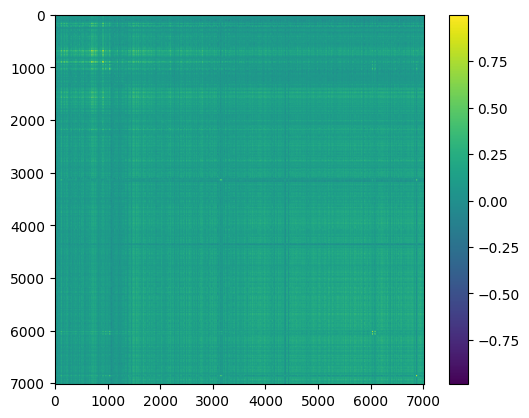

In [118]:
sim[0]

In [110]:
path_first_obs[6440,]

array([ 1.1284730e+00,  4.2973909e-01, -1.6874887e-01,  2.6111741e-02,
        8.2304472e-01,  4.9716972e-02, -5.2695006e-01, -7.4854568e-02,
        4.1253181e+00,  5.0368351e-01,  5.9065133e-01,  7.1575239e-02,
       -5.5339611e-01,  4.8856273e-02,  4.6706698e-03, -2.7414680e+00,
       -1.0000000e+01], dtype=float32)

In [111]:
path_lat_obs[6439,]

array([  1.0641856 ,   0.5022428 ,  -0.22527564,  -1.2424353 ,
        -0.25901487,   0.05204702,  -0.04044164,   0.34649873,
         4.5565157 ,  -0.9760221 ,   0.33938327,  -7.718694  ,
         3.8258088 ,  10.        ,  -0.10568574,  -6.0228014 ,
       -10.        ], dtype=float32)

In [64]:
sim[16,:3]

array([[0.06479738, 0.06450819, 0.06585298],
       [0.08317117, 0.0827905 , 0.0795382 ],
       [0.05712159, 0.05955996, 0.05283558]], dtype=float32)

In [104]:
sim[6439].argsort()[-100:]

array([6249, 2315, 6307, 5000, 3330, 3396, 3087, 5262, 6524, 3785, 5881,
       5165, 5068, 2358, 5114, 6359, 2732, 5629, 3964, 6187, 2427, 4814,
       4887, 4352, 6224, 5442, 4755, 6652, 6607, 4329, 6318, 4596, 4796,
        242, 5019, 6535, 4190, 6044, 3820, 5581, 2812, 5965, 4684, 5736,
       6322, 6642, 3221, 6906, 5779, 5438, 2925, 5527, 6441, 5214, 6251,
       6599, 5562, 5975, 4438, 5893, 5411, 2982, 3363,  241, 6304, 6785,
       4037, 5697, 1996, 4200, 5589, 2627, 4693, 6991, 5661, 5358, 5530,
       4333, 5703, 5729, 6550, 3955, 5049, 6849, 5482, 5175, 1875, 6129,
       3823, 2995, 1295, 4236, 2408, 3953, 3903, 4616, 3935, 4773, 3026,
       3800])

In [106]:
sim[6439][6439:6440]

array([0.26513115], dtype=float32)

[104 125 114 ... 110 128 117]
total_trans: 722401 114.92220808145085 100 128


(array([372., 198., 369., 201., 169., 310., 222., 634., 128., 231., 420.,
        195., 471., 215., 164., 372., 277., 386., 236., 716.]),
 array([100. , 101.4, 102.8, 104.2, 105.6, 107. , 108.4, 109.8, 111.2,
        112.6, 114. , 115.4, 116.8, 118.2, 119.6, 121. , 122.4, 123.8,
        125.2, 126.6, 128. ]),
 <BarContainer object of 20 artists>)

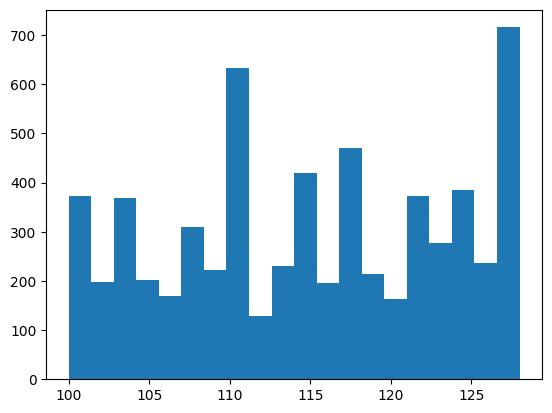

In [47]:
trans_len1 = np.array([trj['obs'].shape[0] for trj in stitch_1])
print(trans_len1)
total_trans = np.sum(trans_len1)
print(f'total_trans: {total_trans}', np.mean(trans_len1), np.min(trans_len1), np.max(trans_len1))
plt.hist(trans_len1, bins=20)

In [47]:
trans_len1[:4]

array([81, 80, 81, 80])

In [84]:
stitch_1[1]['obs'][35:45,15:17]

array([[ 1.2064124 , -0.08866196, -0.00640251, -0.07186686],
       [ 1.2082661 , -0.05502248,  0.00895147, -0.03472582],
       [ 1.2101153 , -0.0237398 ,  0.01892176,  0.00611438],
       [ 1.211246  , -0.00679345,  0.01653492,  0.03904326],
       [ 1.2119056 ,  0.00126318,  0.01423161,  0.05080751],
       [ 1.2110302 ,  0.00141653,  0.01360787,  0.03185162],
       [ 1.2107937 , -0.00135229,  0.01363504,  0.02644316],
       [ 1.2094947 , -0.00316706,  0.0137958 ,  0.02449972],
       [ 1.2094611 , -0.00415523,  0.01365438,  0.02308144],
       [ 1.2088863 , -0.0047212 ,  0.01368637,  0.02106016]],
      dtype=float32)

In [88]:
aug_idx = [aug_list_1[i][1] for i in range(len(aug_list_1))]

In [29]:
np.where(trans_len2 == 80)[0]

array([  87,  135,  142,  163,  502,  507,  553,  595,  629,  807,  883,
        888,  906,  970, 1098, 1139, 1176, 1266, 1277, 1278, 1418, 1534,
       1561, 1584, 1620, 1678, 1753, 1804, 1866, 1981, 2055, 2131, 2132,
       2152, 2253, 2342, 2345, 2484, 2624, 2660, 2665, 2756, 2797, 2886,
       3090, 3106, 3151, 3164, 3354, 3392, 3909, 4005, 4108])

[82 82 82 ... 82 82 82]
total_trans: 392698 81.94866444073456 81 83


(array([ 259.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 4520.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,   13.]),
 array([81. , 81.1, 81.2, 81.3, 81.4, 81.5, 81.6, 81.7, 81.8, 81.9, 82. ,
        82.1, 82.2, 82.3, 82.4, 82.5, 82.6, 82.7, 82.8, 82.9, 83. ]),
 <BarContainer object of 20 artists>)

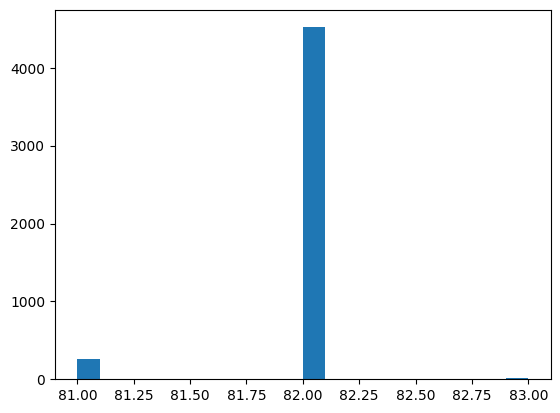

In [136]:
trans_len2 = np.array([trj['obs'].shape[0] for trj in stitch_2])
print(trans_len2)
total_trans = np.sum(trans_len2)
print(f'total_trans: {total_trans}', np.mean(trans_len2), np.min(trans_len2), np.max(trans_len2))
plt.hist(trans_len2, bins=20)

In [28]:
aug_list_2[87]

array([101, 114,  96])

In [24]:
stitch_1_rew = np.array([sum(trj['rew']) for trj in stitch_1])
print(f'stitch1 rew: max: {np.max(stitch_1_rew)}\t mean: {np.mean(stitch_1_rew)}\t min: {np.min(stitch_1_rew)}')

# stitch_2_rew = np.array([sum(trj['rew']) for trj in stitch_2])
# print(f'stitch1 rew: max: {np.max(stitch_2_rew)}\t mean: {np.mean(stitch_2_rew)}\t min: {np.min(stitch_2_rew)}')

stitch1 rew: max: 439.12770318984985	 mean: 282.6796010690622	 min: 169.30892252922058


In [25]:
def comp_epi_return(dataset, discount=0.99):
    discounts = discount ** np.arange(1000)
    r = []
    for seq in dataset:
        rewards = seq['rew']
        
        r_ = 0
        l = len(rewards)
        
        for i in range(l):
            r_ = (discounts[:l-i] * rewards[i:]).sum()
            r.append(r_)
        
    return r

In [26]:
round1_return = np.array(comp_epi_return(stitch_1))
# round2_return = np.array(comp_epi_return(stitch_2))
print(f'traj1 return: max: {np.max(round1_return)}\t, mean: {np.mean(round1_return)}\t min: {np.min(round1_return)}')
# print(f'traj2 return: max: {np.max(round2_return)}\t, mean: {np.mean(round2_return)}\t min: {np.min(round2_return)}')

traj1 return: max: 265.5836302432208	, mean: 111.49977897591957	 min: 1.9787611961364746


(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

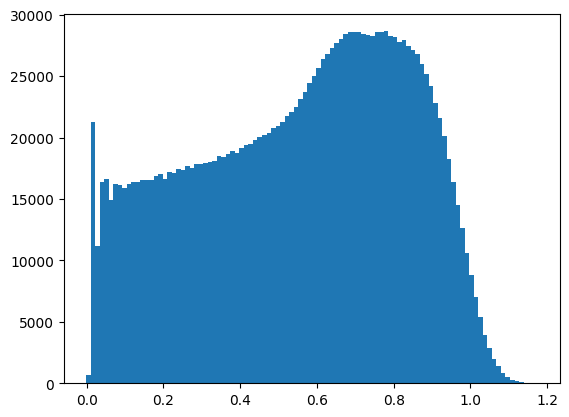

In [28]:
plt.hist(round1_return/300, bins=100)
plt.xticks(size = 10)
plt.yticks(size = 10)

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

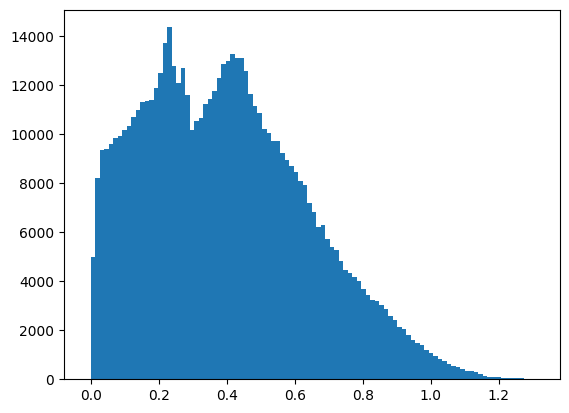

In [32]:
plt.hist(round2_return/200, bins=100)
plt.xticks(size = 10)
plt.yticks(size = 10)